## An Implementation of Gradient Boosting Machine - Deviance Loss Function

This is an attempt to implement toy Gradient Boosting Machine from scratch. Algorithm used is:
<img src="Algorithm.jpg" />
This has been taken from the book Elements of Statistical Learning, Second Edition by Tibshirani, Hastie and Friedman

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_gaussian_quantiles
import copy
import numpy as np
%matplotlib inline
import random
import matplotlib.pyplot as plt
import warnings
from copy import deepcopy
warnings.filterwarnings("ignore")
import csv
import math

In [3]:
def MSE(Data):
    
    #This equation is according to equation 9.12 page 307 of ESL Second Edition
    
    Var = sum((Data[:,2] - np.mean(Data[:,2]))*(Data[:,2] - np.mean(Data[:,2])))
    
    return Var

In [4]:
def InformationGain(Threshold,Data,Feature):
    
    DataL=Data[np.where(Data[:,Feature]>=Threshold)]
    DataR=Data[np.where(Data[:,Feature]<Threshold)]
    
    H_all = MSE(Data)
    
    H_L = MSE(DataL)
    
    H_R = MSE(DataR)

    return H_L + H_R

In [5]:
def GetBestFeature(Data):
        
    Feature1 = []
    
    Feature2 = []
    
    Feature1ThresholdList=np.sort(Data[:,0])
    Feature2ThresholdList=np.sort(Data[:,1])
    
    for k in range(1,len(Data)-1):
            
        InfoGainFeat_1 = InformationGain((Feature1ThresholdList[k-1]+Feature1ThresholdList[k])/2,Data,0)
        InfoGainFeat_2  = InformationGain((Feature2ThresholdList[k-1]+Feature2ThresholdList[k])/2,Data,1)
        
        Feature1.append([InfoGainFeat_1,(Feature1ThresholdList[k-1]+Feature1ThresholdList[k])/2])
        Feature2.append([InfoGainFeat_2,(Feature2ThresholdList[k-1]+Feature2ThresholdList[k])/2])
       
    Feature1 = np.vstack(Feature1)
    Feature2 = np.vstack(Feature2)
    
    BestThresholdFeat_1, ThresholdIndex1 = min(Feature1[:,0]), np.argmin(Feature1[:,0])
    BestThresholdFeat_2, ThresholdIndex2 = min(Feature2[:,0]), np.argmin(Feature2[:,0])

    #When there is a conflict between two features,
    #that is information gain for both are equal,
    #then we randomly select one
    if BestThresholdFeat_1==BestThresholdFeat_2:
        if np.random.choice(2,1)[0]==0:
            return 0,Feature1[ThresholdIndex1,1]   
        else:
            return 1,Feature2[ThresholdIndex2,1]
    elif BestThresholdFeat_1 < BestThresholdFeat_2:
        return 0, Feature1[ThresholdIndex1,1]
    else:
        return 1, Feature2[ThresholdIndex2,1]
    

In [6]:
def CreateStump(BestFeature, SplittingThreshold, FullData):
    
    LeftChildData = FullData[np.where(FullData[:,BestFeature]>=SplittingThreshold)]
    RightChildData = FullData[np.where(FullData[:,BestFeature]<SplittingThreshold)]
    
    LeftChildMean = np.mean(LeftChildData[:,2])
    RightChildMean = np.mean(RightChildData[:,2])
    
    return {'Feature':BestFeature, 'Split':SplittingThreshold, 'LeftChildPred':LeftChildMean, 'RightChildPred':RightChildMean}

In [7]:
def classify(Data,Tree):
    
    if Data[Tree['Feature']]>=Tree['Split']:
        return Tree['LeftChildPred']
    else:
        return Tree['RightChildPred']

In [8]:
def _DecisionTreeRegressor(Data):
    
    BestFeature, SplittingThreshold = GetBestFeature(Data)
    
    Tree = CreateStump(BestFeature, SplittingThreshold, Data)
    
    return Tree

In [24]:
def GBM(DataInput,depth,maxdepth,M,SamplePercent):
    
    # create list of learners
    LearnerList=[]
    
    Data=copy.deepcopy(DataInput)
    
    # concatenate two columns
    # Final structure of the data:
    # Col 1: X1 (feature 1)
    # Col 2: X2 (feature 2)
    # Col 3: Residuals
    # Col 4: "boost" achieved at each step
    # Col 5: Y (class value)
    
    Data=np.c_[Data,np.array([0]*(len(Data))),Data[:,2]]
    
    for m in range(0,M):

        
        # select random rows, based on the "SamplePercent" Value: SamplePercent = 0 to 100
        RandomSelectedAxes=np.random.choice(Data.shape[0], int((len(Data))*(SamplePercent/100)), replace=False)
        
        # In case of binary classification:
        # we need to grow only one regression tree see Ex. 10.10 in ESL
        _f = -1*Data[RandomSelectedAxes,3]
        
        # Calculate log-odd of each class at every step
        p=np.exp(Data[RandomSelectedAxes,3])/(np.exp(Data[RandomSelectedAxes,3])+np.exp(_f))
        
        # Calculate residual
        Data[RandomSelectedAxes,2]=Data[RandomSelectedAxes,4]-p

        # Fit a regression tree to the residuals
        Learner = _DecisionTreeRegressor(Data)

        # Get prediction for each example
        Prediction = []
        for row in Data:
            Prediction.append(classify(row,Learner))
        
        Prediction = np.array(Prediction)
    
        # Get unique Regions R1, R2... Rn
        UniquePredictions = np.unique(Prediction)
        
        # Calculate gamma for each Region
        GammaList = []

        for UqPred in UniquePredictions:
            GammaList.append([UqPred,(1/2)*sum(Data[np.where(Prediction==UqPred)][:,2])/sum((abs(Data[np.where(Prediction==UqPred)][:,2])*(1-abs(Data[np.where(Prediction==UqPred)][:,2]))))])
        
        GammaList=np.array(GammaList)
        
        # Update learner value for each data point
        for k in range(len(Data)):
            Data[k,3]=Data[k,3] + GammaList[GammaList[:,0]==Prediction[k],1]
        
        # Append the learner at this stage to the learner list
        LearnerList.append(Learner)
        
    return LearnerList

In [23]:
def plot(data,learners):
    xx = np.linspace(min(data[:,0])-0.1, max(data[:,0])+0.1, 30)
    yy = np.linspace(min(data[:,1])-0.1, max(data[:,1])+0.1, 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.array(np.vstack([XX.ravel(), YY.ravel()]).T)

    pred=[0]*len(xy)
    pred=np.array(pred)
    Threshold=[0]*len(xy)
    for i in range(0,len(xy)):
        for tree_model in learners:

            Threshold[i] = Threshold[i]+classify(xy[i,:].reshape(1,-1)[0],tree_model)

        if Threshold[i]>=0:
            pred[i]=1
        else:
            pred[i]=0
    
    Z=pred.reshape(XX.shape)
    f = plt.figure(figsize=(14,5))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.scatter(data[:,0], data[:,1],c=data[:,2],s=50,edgecolors='black')
    plt.subplot(122)
    ax2.contourf(XX, YY, Z,cmap=plt.cm.coolwarm,alpha=0.9)
    ax2.scatter(data[:,0], data[:,1],c=data[:,2],s=50,edgecolors='black')
    plt.show()

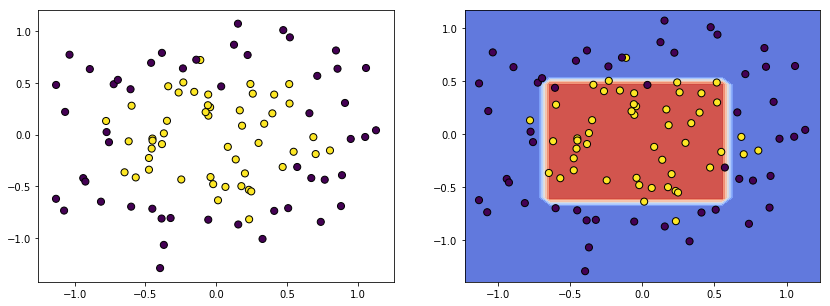

In [25]:
X,Y=make_circles(noise=0.2, factor=0.5, random_state=1)
data=np.append(X,Y.reshape(-1,1),axis=1)

M=5
learners =GBM(np.copy(data),0,1,M,100)
plot(data,learners)

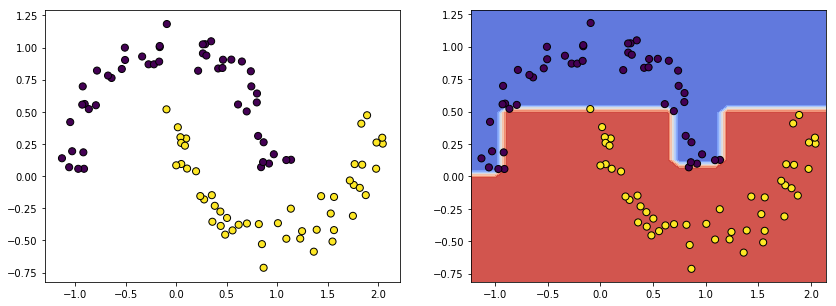

In [27]:
X,Y=make_moons(n_samples=100, shuffle=True, noise=0.1, random_state=100)
data=np.append(X,Y.reshape(-1,1),axis=1)

M=10
learners = GBM(copy.deepcopy(data),0,1,M,100)
plot(data,learners)

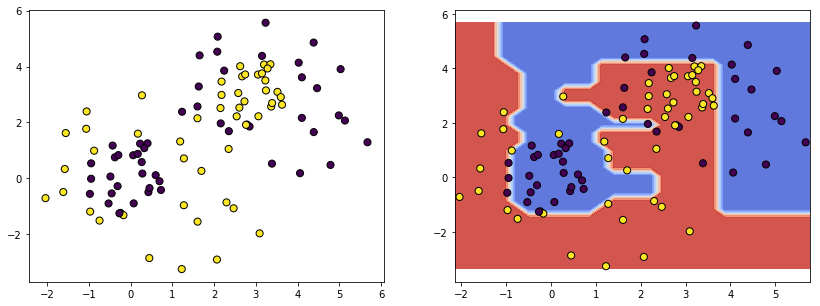

In [28]:
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=50, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=50, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
Y = np.concatenate((y1, - y2 + 1))

data=np.append(X,Y.reshape(-1,1),axis=1)

M=100
learners=GBM(copy.deepcopy(data),0,1,M,100)
plot(data,learners)

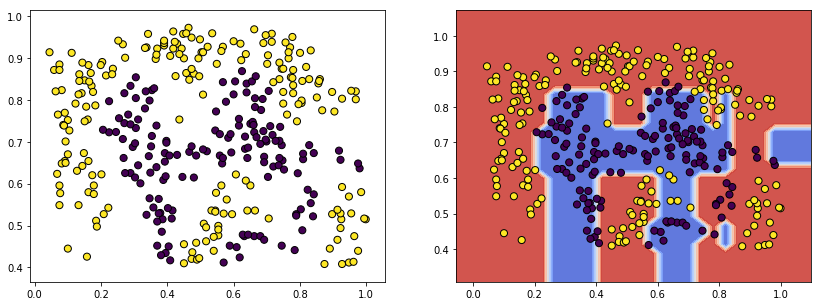

In [31]:
data_2=[]
with open("ex8a.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        data_2.append(row)
    f.close()
    
data_2=np.array(np.vstack(data_2))
data=np.ndarray.astype(data_2,float)

RandomSelectedAxes=np.random.choice(data.shape[0], int((len(data))*(40/100)), replace=False)
data=data[RandomSelectedAxes,:]

M=100
learners=GBM(copy.deepcopy(data),0,1,M,100)
plot(data,learners)